In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import math

# Pre-Calculations


In [2]:
prices_2 = pd.read_csv('prices_round_4_day_3.csv', sep=';')
prices_1 = pd.read_csv('prices_round_4_day_2.csv', sep=';')
prices_0 = pd.read_csv('prices_round_4_day_1.csv', sep=';')

trades_2 = pd.read_csv('trades_round_4_day_3_nn.csv', sep=';')
trades_1 = pd.read_csv('trades_round_4_day_2_nn.csv', sep=';')
trades_0 = pd.read_csv('trades_round_4_day_1_nn.csv', sep=';')

In [3]:
df = pd.concat([prices_2, prices_1, prices_0]).reset_index(drop=True)

In [4]:
df.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,3,0,COCONUT,9990.0,148.0,9989.0,61.0,NaN,NaN,9992,209,NaN,NaN,NaN,NaN,9991.0,0.0
1,3,0,COCONUT_COUPON,619.0,46.0,NaN,NaN,NaN,NaN,621,46,NaN,NaN,NaN,NaN,620.0,0.0
2,3,100,COCONUT,9989.0,171.0,NaN,NaN,NaN,NaN,9991,114,9992.0,57.0,NaN,NaN,9990.0,0.0
3,3,100,COCONUT_COUPON,620.0,32.0,NaN,NaN,NaN,NaN,621,32,NaN,NaN,NaN,NaN,620.5,0.0
4,3,200,COCONUT,9990.0,135.0,9989.0,57.0,NaN,NaN,9991,135,9992.0,57.0,NaN,NaN,9990.5,0.0


In [5]:
df["product"].unique()

array(['COCONUT', 'COCONUT_COUPON'], dtype=object)

In [6]:
coconut_prices = df[df["product"] == "COCONUT"].reset_index(drop=True)
coupon_prices = df[df["product"] == "COCONUT_COUPON"].reset_index(drop=True)

In [7]:
def calc_vwap(prices_df):
    total_bid_volume = (
        prices_df["bid_volume_1"].fillna(0)
        + prices_df["bid_volume_2"].fillna(0)
        + prices_df["bid_volume_3"].fillna(0)
    )
    total_ask_volume = (
        prices_df["ask_volume_1"].fillna(0)
        + prices_df["ask_volume_2"].fillna(0)
        + prices_df["ask_volume_3"].fillna(0)
    )

    vwap = (
        prices_df["bid_price_1"].fillna(0) * prices_df["bid_volume_1"].fillna(0)
        + prices_df["bid_price_2"].fillna(0) * prices_df["bid_volume_2"].fillna(0)
        + prices_df["bid_price_3"].fillna(0) * prices_df["bid_volume_3"].fillna(0)
        + prices_df["ask_price_1"].fillna(0) * prices_df["ask_volume_1"].fillna(0)
        + prices_df["ask_price_2"].fillna(0) * prices_df["ask_volume_2"].fillna(0)
        + prices_df["ask_price_3"].fillna(0) * prices_df["ask_volume_3"].fillna(0)
    ) / (total_bid_volume + total_ask_volume)

    return vwap

In [8]:
coconut_prices["vwap"] = calc_vwap(coconut_prices)
coupon_prices["vwap"] = calc_vwap(coupon_prices)

In [9]:
cols = ["day", "timestamp", "mid_price", "vwap"]
merge = pd.merge(coconut_prices[cols], coupon_prices[cols], on=['day', 'timestamp'], how='inner', suffixes=('_coconut', '_coupon'))

merge.rename(columns={"mid_price": "mid_price_coconut", "vwap": "vwap_coconut"}, inplace=True)
merge.head()

,day,timestamp,mid_price_coconut,vwap_coconut,mid_price_coupon,vwap_coupon
0,3,0,9991.0,9990.854067,620.0,620.0
1,3,100,9990.0,9990.166667,620.5,620.5
2,3,200,9990.5,9990.500000,620.5,620.5
3,3,300,9991.5,9991.500000,621.5,621.5
4,3,400,9990.0,9989.872093,621.5,621.5


In [11]:
merge['shifted_coconut_price'] = merge['mid_price_coconut'].shift(-1)
merge = merge.dropna()
merge['unit_increase_coconut'] = merge['mid_price_coconut'] - merge['shifted_coconut_price']
merge['unit_increase_coconut'].describe()

<ipython-input-11-e545f47beb05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge['unit_increase_coconut'] = merge['mid_price_coconut'] - merge['shifted_coconut_price']


count    29999.000000
mean        -0.004800
std          1.787938
min       -253.000000
25%         -0.500000
50%          0.000000
75%          0.500000
max          4.500000
Name: unit_increase_coconut, dtype: float64

In [12]:
sorted = merge.sort_values(by='unit_increase_coconut', ascending=True)
print(sorted)

       day  timestamp  mid_price_coconut  vwap_coconut  mid_price_coupon  \
9999     3     999900             9882.5   9882.492611             575.5   
19999    2     999900             9990.0   9990.176887             620.5   
21111    1     111100             9959.0   9958.802198             615.5   
3929     3     392900             9883.0   9883.190476             572.5   
16909    2     690900            10013.0  10013.202128             643.5   
...    ...        ...                ...           ...               ...   
5399     3     539900             9866.0   9865.854730             568.5   
25920    1     592000            10055.0  10054.815508             669.5   
6370     3     637000             9851.0   9850.862069             565.5   
19891    2     989100             9982.5   9982.500000             634.5   
21136    1     113600             9964.0   9963.841014             617.5   

       vwap_coupon  shifted_coconut_price  unit_increase_coconut  
9999         575.5  

# Black Scholes Calculations

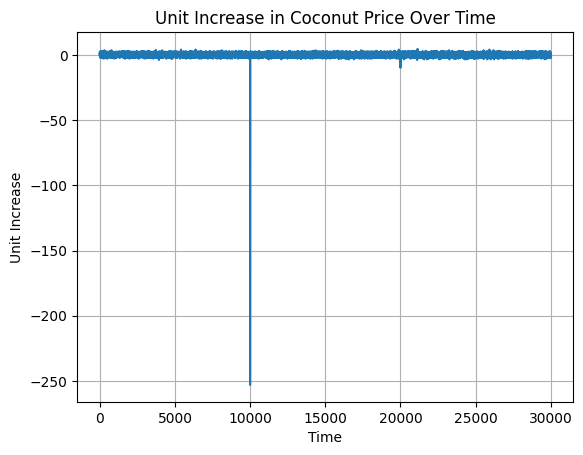

In [13]:
plt.plot(merge['unit_increase_coconut'])
plt.title('Unit Increase in Coconut Price Over Time')
plt.xlabel('Time')
plt.ylabel('Unit Increase')
plt.grid(True)
plt.show()

In [14]:
merge = merge[merge['unit_increase_coconut'] > -11]
value_counts = merge['unit_increase_coconut'].value_counts()
value_counts_filtered = value_counts[value_counts.index != -253.0]
print(value_counts_filtered)

unit_increase_coconut
 0.0     6024
-0.5     5151
 0.5     5008
 1.0     3735
-1.0     3564
-1.5     1967
 1.5     1916
 2.0      901
-2.0      855
 2.5      343
-2.5      324
-3.0       95
 3.0       81
-3.5       15
 3.5       11
 4.0        4
-4.0        2
-10.0       1
 4.5        1
Name: count, dtype: int64


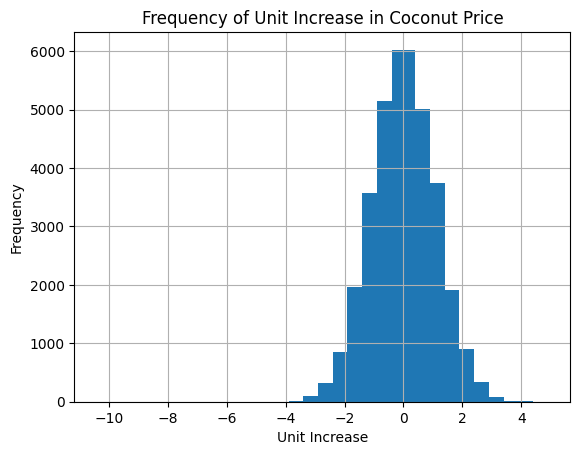

In [15]:
# Plot the bar graph
plt.bar(value_counts.index, value_counts.values)
plt.title('Frequency of Unit Increase in Coconut Price (CDF)')
plt.xlabel('Unit Increase')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [20]:
merge['log_price_coconut'] = np.log(merge['mid_price_coconut'])
merge['shifted_log_price_coconut'] = merge['log_price_coconut'].shift(-1)
merge['log_returns_coconut'] = merge['log_price_coconut'] - merge['shifted_log_price_coconut']
merge = merge.dropna()
merge['log_returns_coconut'].describe()

count    2.999600e+04
mean    -4.754220e-07
std      1.779843e-04
min     -2.512682e-02
25%     -5.061625e-05
50%      0.000000e+00
75%      5.064445e-05
max      4.517279e-04
Name: log_returns_coconut, dtype: float64

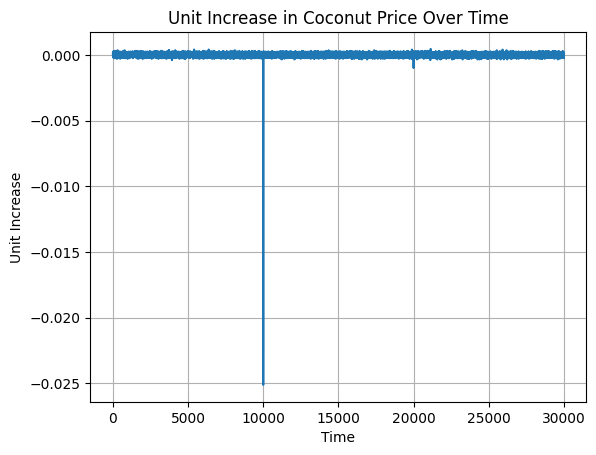

In [21]:
plt.plot(merge['log_returns_coconut'])
plt.title('Unit Increase in Coconut Price Over Time')
plt.xlabel('Time')
plt.ylabel('Unit Increase')
plt.grid(True)
plt.show()